# SteganoGAN in Keras
This notebook contains code attempting to reimplement SteganoGAN in Keras, for the purpose of better understanding (and scrutinizing) it.

*Based on https://github.com/DAI-Lab/SteganoGAN/tree/master/steganogan*

### Modules

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import sys

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

from resnet_steganogan_gp import SteganoGAN
from models import DenseEncoder, DenseDecoder, Critic

2025-02-10 22:53:51.230583: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Constants

In [2]:
# Image dimensions
IMAGE_HEIGHT = 360
IMAGE_WIDTH = 360
IMAGE_CHANNELS = 3

IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
MESSAGE_DEPTH = 3
BATCH_SIZE = 4
MODEL_PATH = 'SteganoGAN.weights.h5'

IMAGES_TESTING_PATH = 'images/testing'
IMAGES_OUTPUT_PATH = 'images/testing_output'

----

### Call main encode and decode functions (with creating steganographic image and decoding it)

In [3]:
encoder = DenseEncoder(MESSAGE_DEPTH)
decoder = DenseDecoder(MESSAGE_DEPTH)
critic = Critic()

encoder.build(input_shape=[(None, None, None, IMAGE_CHANNELS), (None, None, None, MESSAGE_DEPTH)])
decoder.build(input_shape=(None, None, None, IMAGE_CHANNELS))
critic.build(input_shape=(None, None, None, IMAGE_CHANNELS))

stegano_gan = SteganoGAN(
  encoder=encoder,
  decoder=decoder,
  critic=critic,
  data_depth=MESSAGE_DEPTH,
  image_shape=IMAGE_SHAPE
)

stegano_gan.build(input_shape=[(None, None, None, IMAGE_CHANNELS), (None, None, None, MESSAGE_DEPTH)])

if MODEL_PATH is not None and os.path.exists(MODEL_PATH):
  stegano_gan.load_weights(MODEL_PATH)
  print(f'Model loaded from {MODEL_PATH}')

stegano_gan.compile(
  encoder_decoder_optimizer  = Adam(learning_rate=1e-4),
  critic_optimizer           = Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9),
  similarity_loss_fn         = MeanSquaredError(),
  decoder_loss_fn            = BinaryCrossentropy(from_logits=True) # false means that data to compare is in [0, 1]
)

Model loaded from SteganoGAN.weights.h5


In [4]:
stegano_gan.encode(f'{IMAGES_TESTING_PATH}/input1.png', f'{IMAGES_OUTPUT_PATH}/output1.png', 'Hello, World! 1111')
print(stegano_gan.decode(f'{IMAGES_OUTPUT_PATH}/output1.png'))

ValueError: Failed to find message.

In [5]:
stegano_gan.encode(f'{IMAGES_TESTING_PATH}/input2.png', f'{IMAGES_OUTPUT_PATH}/output2.png', 'Hello, World! 2222')
print(stegano_gan.decode(f'{IMAGES_OUTPUT_PATH}/output2.png'))

ValueError: Failed to find message.

In [6]:
stegano_gan.encode(f'{IMAGES_TESTING_PATH}/input3.png', f'{IMAGES_OUTPUT_PATH}/output3.png', 'Hello, World! 3333')
print(stegano_gan.decode(f'{IMAGES_OUTPUT_PATH}/output3.png'))

ValueError: Failed to find message.

In [9]:
stegano_gan.encode(f'{IMAGES_TESTING_PATH}/input4.png', f'{IMAGES_OUTPUT_PATH}/output4.png', 'Hello, World! 4444')
print(stegano_gan.decode(f'{IMAGES_OUTPUT_PATH}/output4.png'))

ValueError: Failed to find message.

### SteganoGAN predict random data with metrics

In [ ]:
cover_image = tf.random.uniform([1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS], -1, 1, dtype=tf.float32)
message = tf.cast(tf.random.uniform([1, IMAGE_HEIGHT, IMAGE_WIDTH, MESSAGE_DEPTH], 0, 2, dtype=tf.int32), tf.float32)

stego_img, recovered_msg = stegano_gan.predict([cover_image, message])

print("stego_img min: {0}, max: {1}".format(tf.reduce_min(stego_img), tf.reduce_max(stego_img)))
print("recovered_msg min: {0}, max: {1}".format(tf.reduce_min(recovered_msg), tf.reduce_max(recovered_msg)))

print("BinaryCrossentropy: {0}".format(BinaryCrossentropy(from_logits=True)(message, recovered_msg)))
print("PSNR: {0}".format(tf.reduce_mean(tf.image.psnr(cover_image, stego_img, 1))))
print("SSIM: {0}".format(tf.reduce_mean(tf.image.ssim(cover_image, stego_img, 1))))

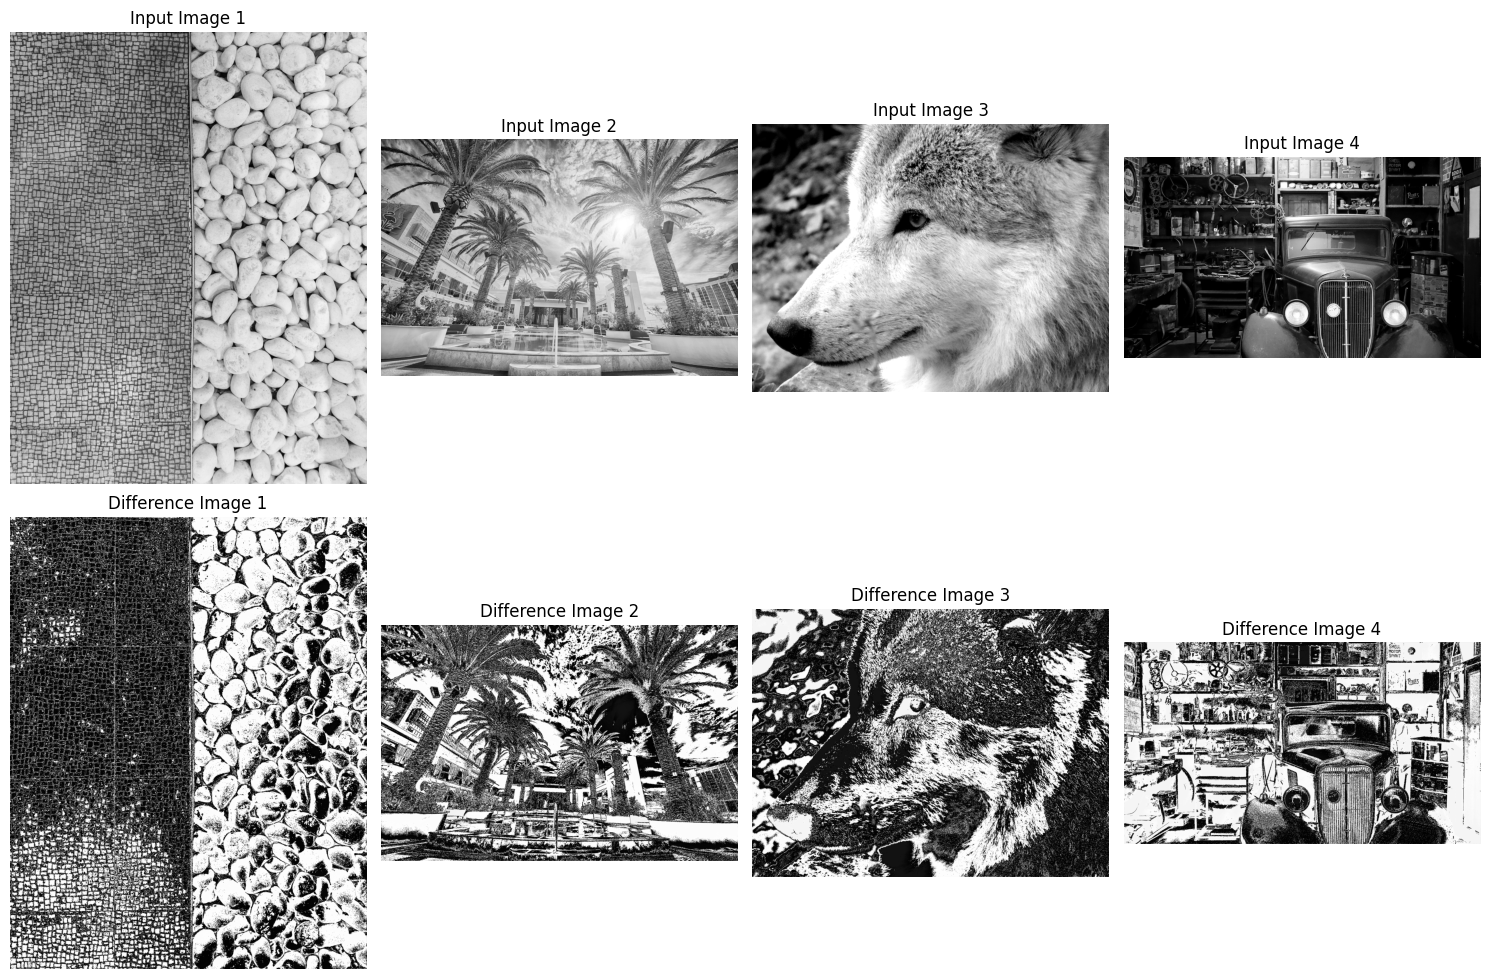

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load images
input_image_paths = [f'{IMAGES_TESTING_PATH}/input{i}.png' for i in range(1, 5)]
output_image_paths = [f'{IMAGES_OUTPUT_PATH}/output{i}.png' for i in range(1, 5)]

input_images = [Image.open(path).convert('L') for path in input_image_paths]
output_images = [Image.open(path).convert('L') for path in output_image_paths]

# Convert images to numpy arrays
input_images_np = [np.array(img) for img in input_images]
output_images_np = [np.array(img) for img in output_images]

# Calculate the absolute difference between the images
difference_images_np = [np.abs(input_np - output_np) for input_np, output_np in zip(input_images_np, output_images_np)]

# Convert the difference images to PIL images
difference_images = [Image.fromarray(diff_np.astype('uint8')) for diff_np in difference_images_np]

# Plot the images
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

for i in range(4):
  axes[0, i].imshow(input_images[i], cmap='gray')
  axes[0, i].set_title(f'Input Image {i+1}')
  axes[0, i].axis('off')

  axes[1, i].imshow(difference_images[i], cmap='gray')
  axes[1, i].set_title(f'Difference Image {i+1}')
  axes[1, i].axis('off')

plt.tight_layout()
plt.show()

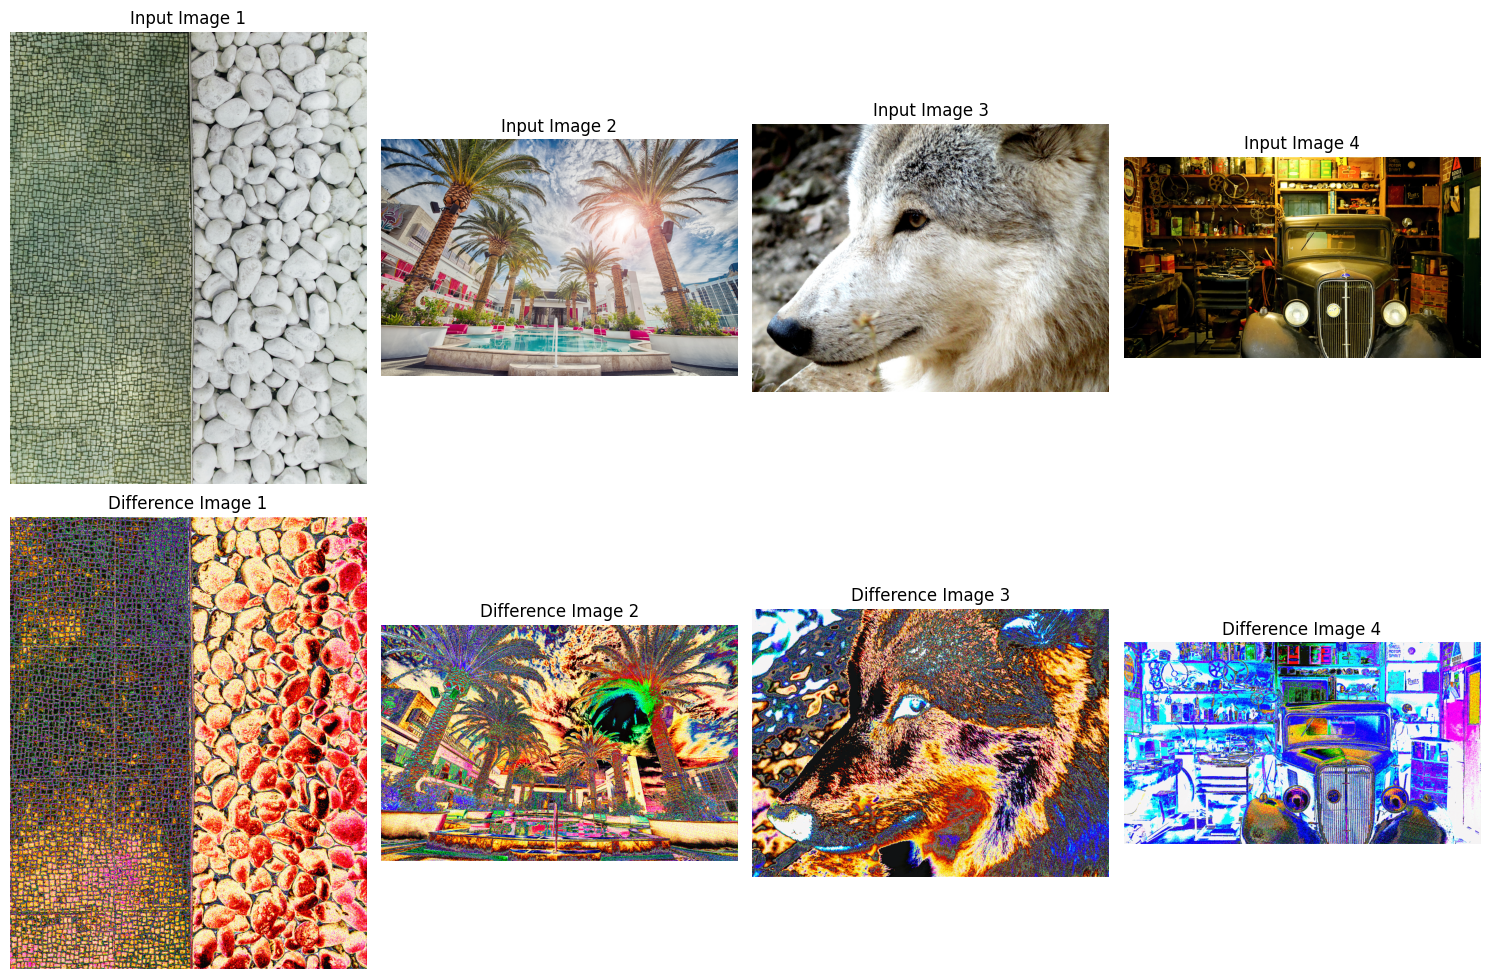

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load images
input_image_paths = [f'{IMAGES_TESTING_PATH}/input{i}.png' for i in range(1, 5)]
output_image_paths = [f'{IMAGES_OUTPUT_PATH}/output{i}.png' for i in range(1, 5)]

input_images = [Image.open(path).convert('RGB') for path in input_image_paths]
output_images = [Image.open(path).convert('RGB') for path in output_image_paths]

# Convert images to numpy arrays
input_images_np = [np.array(img) for img in input_images]
output_images_np = [np.array(img) for img in output_images]

# Calculate the absolute difference between the images
difference_images_np = [np.abs(input_np - output_np) for input_np, output_np in zip(input_images_np, output_images_np)]

# Convert the difference images to PIL images
difference_images = [Image.fromarray(diff_np.astype('uint8')) for diff_np in difference_images_np]

# Plot the images
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

for i in range(4):
  axes[0, i].imshow(input_images[i])
  axes[0, i].set_title(f'Input Image {i+1}')
  axes[0, i].axis('off')

  axes[1, i].imshow(difference_images[i])
  axes[1, i].set_title(f'Difference Image {i+1}')
  axes[1, i].axis('off')

plt.tight_layout()
plt.show()